In [59]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sounddevice as sd
from scipy.io import wavfile
from scipy import signal
from pydub import AudioSegment

In [60]:
f = "Ensoniq-SQ-1-Biwa-C4.wav"

samplerate, data = wavfile.read(f)

C:\Users\Иван\AppData\Local\Temp\ipykernel_45332\120721754.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read(f)


In [61]:
duration = len(data) / samplerate
time = np.arange(0, duration, 1/samplerate)

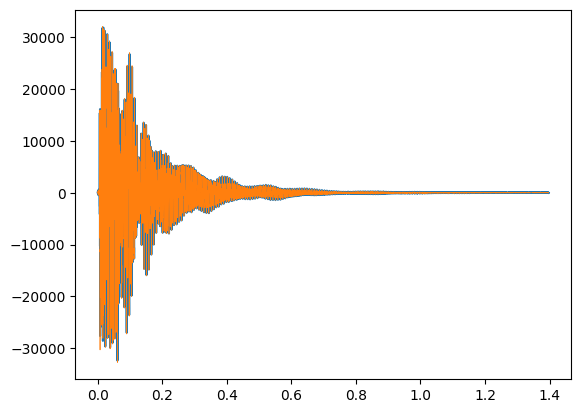

In [62]:
plt.plot(time, data[:, 1])
plt.plot(time, data[:, 0], linewidth=0.5)
plt.show()

In [63]:
sd.play(data[:, :], samplerate)
sd.wait()

C:\Users\Иван\AppData\Local\Temp\ipykernel_45332\2062163445.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(np.linspace(0, data.shape[0] / s, data.shape[0]), a, "-k", color="purple")


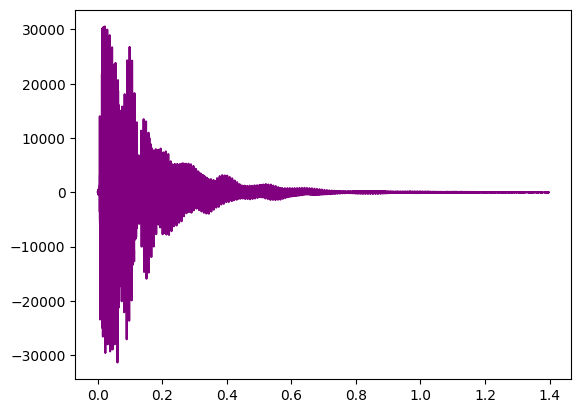

In [64]:
asegment = AudioSegment.from_wav(f)
asegment = asegment.set_channels(1)
asegment.export("mono.wav", format="wav")
s, a = wavfile.read("mono.wav")
plt.plot(np.linspace(0, data.shape[0] / s, data.shape[0]), a, "-k", color="purple")
plt.show()

In [65]:
sd.play(a, data.shape[0])
sd.wait()

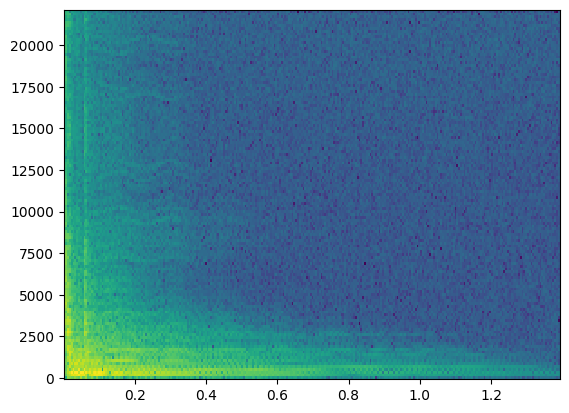

In [66]:
adata = data[:, 0]
s = samplerate

fr, tm, spgram = signal.spectrogram(adata, s)
lspg = np.log(spgram)
plt.pcolormesh(tm, fr, lspg, shading="auto")
plt.show()

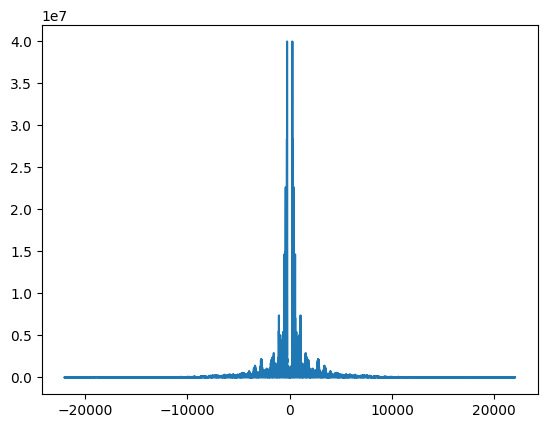

In [67]:
from scipy.fft import fft, fftfreq

rN = int(len(data))

yf = fft(data[:, 0])
xf = fftfreq(rN, samplerate ** (-1))

plt.plot(xf, np.abs(yf))

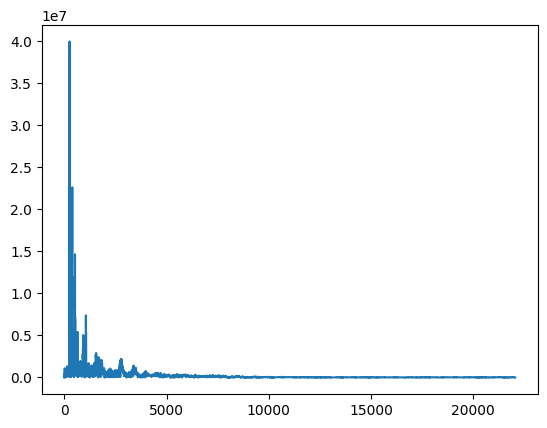

In [68]:
from scipy.fft import rfft, rfftfreq

ryf = rfft(data[:, 0])
rxf = rfftfreq(rN, samplerate ** (-1))

plt.plot(rxf, np.abs(ryf))

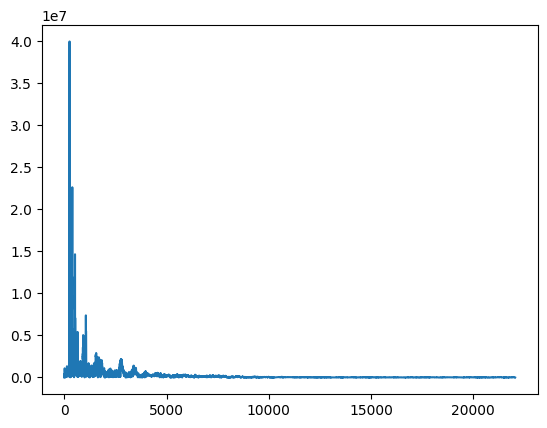

In [69]:
points_per_freq = len(rxf) / (samplerate / 2)

target_idx = int(points_per_freq * 3000)
ryf[target_idx-2:target_idx+2] = 0

plt.plot(rxf, np.abs(ryf))

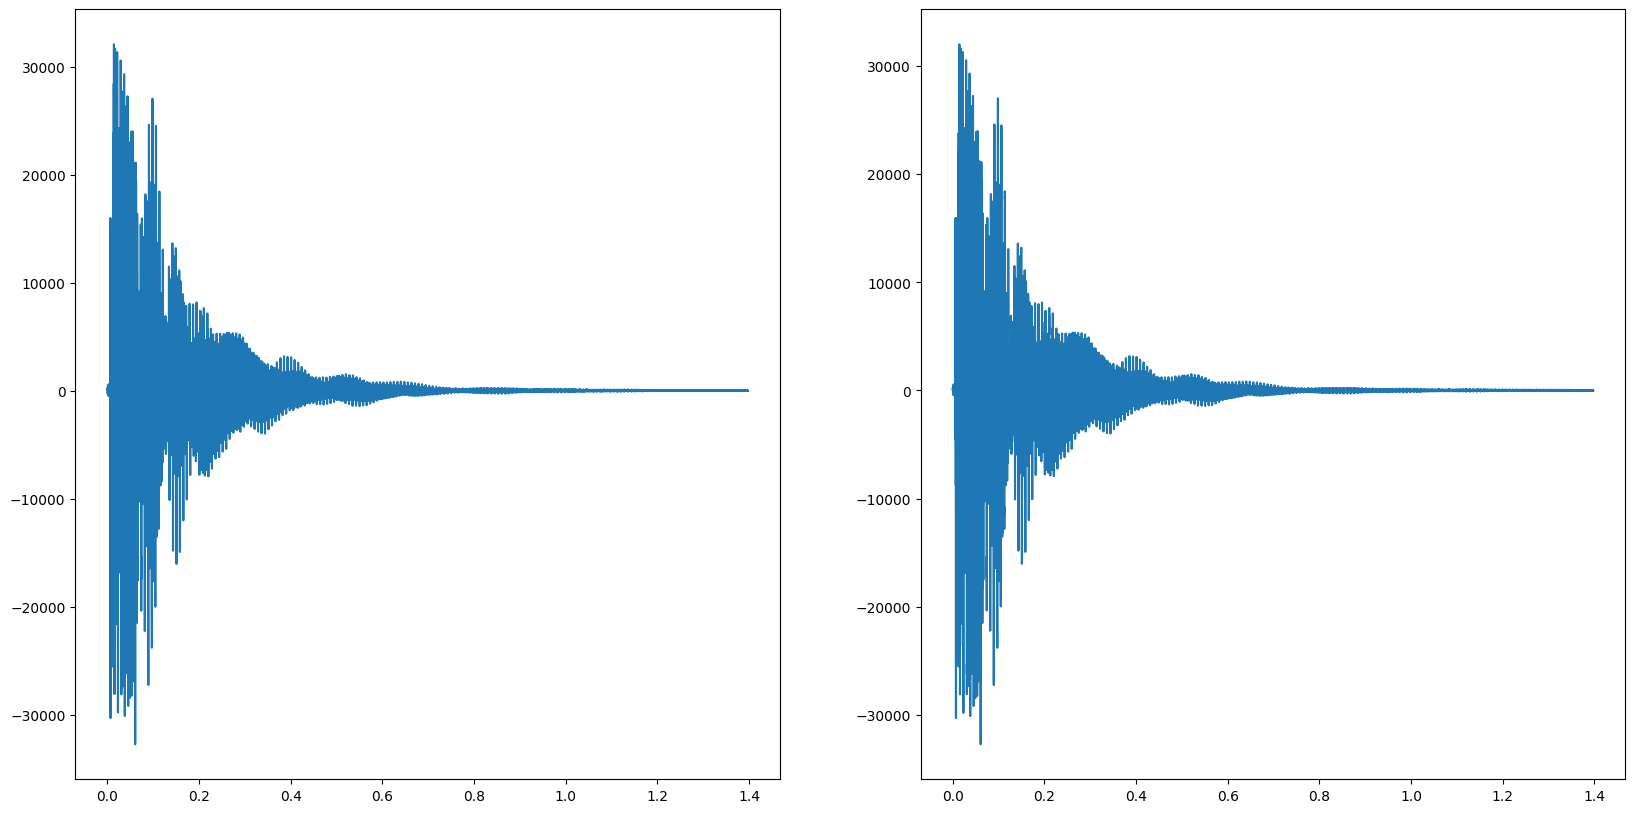

In [70]:
from scipy.fft import irfft

new_sig = irfft(ryf)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].plot(time, data[:, 0])
ax[1].plot(time[:len(new_sig)], new_sig)
plt.show()

In [71]:
sd.play(data[:, 0], samplerate)
sd.wait()
sd.play(new_sig, samplerate)
sd.wait()

### Мэл - коэффициенты

In [72]:
def B(b):
    return np.log(b / 700 + 1) * 1125

def Bm1(b):
    return 700 * (np.exp(b / 1125) - 1)

def f(fs, N, M, m):
    f1 = B(0)
    fh = B(fs)
    return (N / fs) * Bm1(B(f1) + m * (B(fh) - B(f1)) / (M + 1))

def H(fs, N, M, m):
    rst = []
    for k in range(N):
        if k < f(fs, N, M, m - 1):
            rst.append(0)
            continue
        if k < f(fs, N, M, m):
            rst.append((k - f(fs, N, M, m - 1)) / (f(fs, N, M, m) - f(fs, N, M, m - 1)))
            continue
        if k < f(fs, N, M, m + 1):
            rst.append((f(fs, N, M, m + 1) - k) / (f(fs, N, M, m + 1) - f(fs, N, M, m)))
            continue
        rst.append(0)
    return np.array(rst)

In [73]:
x = data[:, 0][:]
N = len(x)
M = 12


x_exp = np.array([np.exp(-2 * np.pi * 1j * idx / len(x)) for idx in range(N)])
x_prev = np.array([1] * len(x))
x_np = np.array(x)
X = [np.sum(x)+0j]
for i  in range(1, len(x)):
    x_prev = x_prev * x_exp
    X.append(np.sum(x_np * x_prev))
X = np.array(X)
S = np.array([np.log(np.sum(np.abs(X * X) * H(np.max(np.abs(x)), N, M, m))) for m in range(M)])
c = np.array([np.sum([S[m]*np.cos(np.pi * n * (m + 0.5) / M) for m in range(M)]) for n in range(M)])

In [74]:
print(*c)

409.36347915948255 5.4936818619370555 -3.5038948020083396 -4.781275632013191 -6.607233762079627 -4.980559069881171 -6.578469437661742 -2.2899450608755423 -2.223483256160808 -0.821131573611563 0.21302691470491908 -2.4019394943577383
